### Masked Language Modeling Task

That's [mask] she [mask] -> That's what she said

### Next Sentence Prediction
Input = [CLS] That's [mask] she [mask]. [SEP] Hahaha, nice! [SEP]
<br>Label = IsNext

Input = [CLS] That's [mask] she [mask]. [SEP] Dwight, you ignorant [mask]! [SEP]
<br>Label = NotNext

### CRATE CUSTOM DATASET

In [11]:
import json
import pandas as pd
import numpy as np
import PIL
import urllib
from tqdm import tqdm

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [4]:
dataset_path = Path('dataset')
print(dataset_path.resolve())

/media/idham/SpaceX/333_workspace/my_lab/0_sentiment_analysis/dataset


In [5]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

In [6]:
app_infos = []

for app_id in tqdm(app_packages):
  info = app(app_id, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [01:07<00:00,  4.51s/it]


In [7]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [8]:
print_json(app_infos[0])

{
  "adSupported": false,
  "appId": "com.anydo",
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "\ud83e\udd47 <b>\"#1 to do list app out there\u201d</b> - WSJ\r\n\ud83c\udfc6 <b>Editor's Choice</b> by Google\r\n\r\nOver 30M people rely on Any.do to stay organized and get more done.\r\nIt's a simple to do list app with reminders, planner & calendar - all in one.\r\n\r\n<b>\ud83e\udd47 \"A MUST HAVE APP\" (Lifehacker, NYTimes, USA TODAY).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists, and more.\r\n\r\nOrganize your tasks & to-do list\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day Calendar view, Weekly calendar view & agenda vi

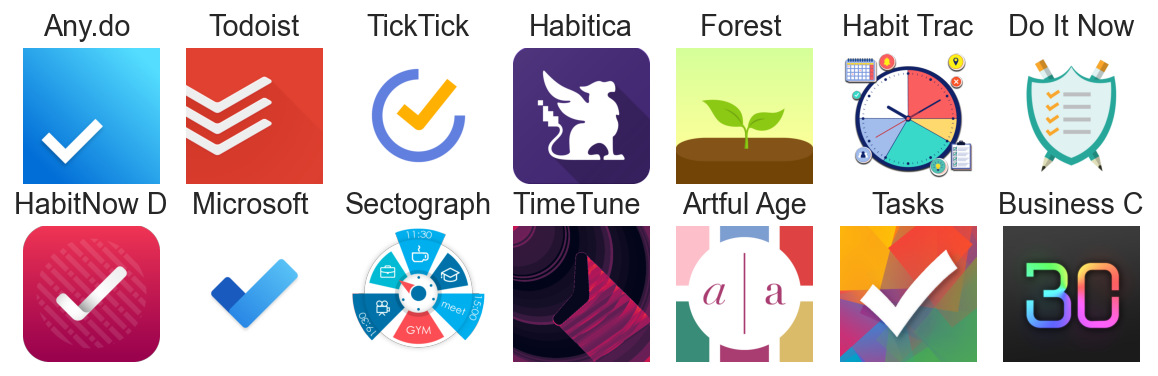

In [13]:
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

fig, axs = plt.subplots(2, len(app_infos)//2, figsize=(10,3))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    # img = plt.imread(ai['icon']) # deprecated
    img = np.array(PIL.Image.open(urllib.request.urlopen(ai['icon'])))
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

In [15]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head(n=2)

,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,reviews,...,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,Any.do - To do list & Calendar,"🥇 <b>""#1 to do list app out there”</b> - WSJ\r...",🥇 <b>&quot;#1 to do list app out there”</b> - ...,"Simple planner with to-do list, tasks, reminde...","10,000,000+",10000000,28213161,4.370599,438079,35676,...,None,False,False,"Nov 10, 2011",1644346628,Varies with device,What's new?\r\n- Filters! You can now filter y...,What&#39;s new?<br>- Filters! You can now filt...,com.anydo,https://play.google.com/store/apps/details?id=...
1,Todoist: To-Do List & Tasks,"🏆 <b>2020 Editor's Choice</b> by Google\r\n🥇 ""...",🏆 <b>2020 Editor&#39;s Choice</b> by Google<br...,“The best to-do list app right now” - The Verg...,"10,000,000+",10000000,34475908,4.508765,242959,15551,...,None,False,False,"Nov 18, 2012",1657188947,Varies with device,The regular fine-tuning you’ve come to expect....,The regular fine-tuning you’ve come to expect....,com.todoist,https://play.google.com/store/apps/details?id=...


In [16]:
app_infos_df.to_csv(Path(dataset_path, 'apps.csv'), index=None, header=True)

### Get APP Reviews

In [18]:
app_reviews = []

for app_id in tqdm(app_packages):
    for score in range(1, 6):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                app_id,
                lang='en',
                country='us',
                sort=sort_order,
                count=200 if score==3 else 100,
                filter_score_with=score
            )
            
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appID'] =  app_id
            app_reviews.extend(rvs)

100%|██████████| 15/15 [06:12<00:00, 24.82s/it]


In [19]:
print_json(app_reviews[0])

{
  "appID": "com.anydo",
  "at": "2022-04-25 20:25:21",
  "content": "I used to love this app. I have used it for years. I even had (until yesterday) the paid version. I primarily use this app to sync up my alexa tasks. It started having issues, then got fixed. Now the company is saying that Amazon sync is no longer usable (unless you want to add a 3rd party to allow it access to your Amazon account).",
  "repliedAt": "2022-04-26 21:23:39",
  "replyContent": "Unfortunately, Amazon has rejected our fix and will not be reopening the Any.do Skill just yet.\nAt this point in time, our efforts seem to be blocked and we will not be able to offer with any estimate to when the integration will be reactivated :(",
  "reviewCreatedVersion": "5.15.4.2",
  "reviewId": "99974541-f5b2-4b30-8053-77d120d6d6e3",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 42,
  "userImage": "https://play-lh.googleusercontent.com/a/AItbvmmQPJYxIfJElW63xmARQfhHw3ixB9-wG3fSQ_3n=mo",
  "userName": "Br

In [20]:
len(app_reviews)

17180

In [21]:
app_reviews_df = pd.DataFrame(app_reviews)

app_reviews_df.to_csv(Path(dataset_path, 'reviews.csv'), index=None, header=True)

# We’ll need the Transformers library by Hugging Face

In [105]:
import os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
df = pd.read_csv(Path(dataset_path, 'reviews.csv'))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appID
0,99974541-f5b2-4b30-8053-77d120d6d6e3,Brent Schoemann,https://play-lh.googleusercontent.com/a/AItbvm...,I used to love this app. I have used it for ye...,1,42,5.15.4.2,2022-04-25 20:25:21,"Unfortunately, Amazon has rejected our fix and...",2022-04-26 21:23:39,most_relevant,com.anydo
1,ab1187e6-3bfd-4999-a1a5-253baaf58a6a,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AFdZu...,"As a programmer, this is absolutely the most l...",1,79,5.15.3.0,2022-01-22 15:03:48,We are sorry you feel this way! We encourage u...,2022-01-24 13:29:17,most_relevant,com.anydo
2,5e2e456d-68b6-4af2-b251-f132a7ea9fb5,Anthony Cannon,https://play-lh.googleusercontent.com/a/AItbvm...,Redoing my review after messaging with the app...,1,83,5.15.3.0,2022-01-22 17:04:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 13:28:12,most_relevant,com.anydo
3,e056d73d-0ff3-4890-8848-8cfdfb63b7be,Emie Hickman,https://play-lh.googleusercontent.com/a-/AFdZu...,After a task is done a duplicate will appear f...,1,2,NaN,2022-02-22 06:54:11,We would be happy to help you resolve all of t...,2022-02-24 20:04:04,most_relevant,com.anydo
4,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,24,4.12.0.5,2019-01-12 16:50:28,"We are sorry you feel this way, please note th...",2019-01-27 19:14:37,most_relevant,com.anydo


In [24]:
df.shape

(17180, 12)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17180 entries, 0 to 17179
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17180 non-null  object
 1   userName              17180 non-null  object
 2   userImage             17180 non-null  object
 3   content               17180 non-null  object
 4   score                 17180 non-null  int64 
 5   thumbsUpCount         17180 non-null  int64 
 6   reviewCreatedVersion  14481 non-null  object
 7   at                    17180 non-null  object
 8   replyContent          9049 non-null   object
 9   repliedAt             9049 non-null   object
 10  sortOrder             17180 non-null  object
 11  appID                 17180 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


Text(0.5, 0, 'review score')

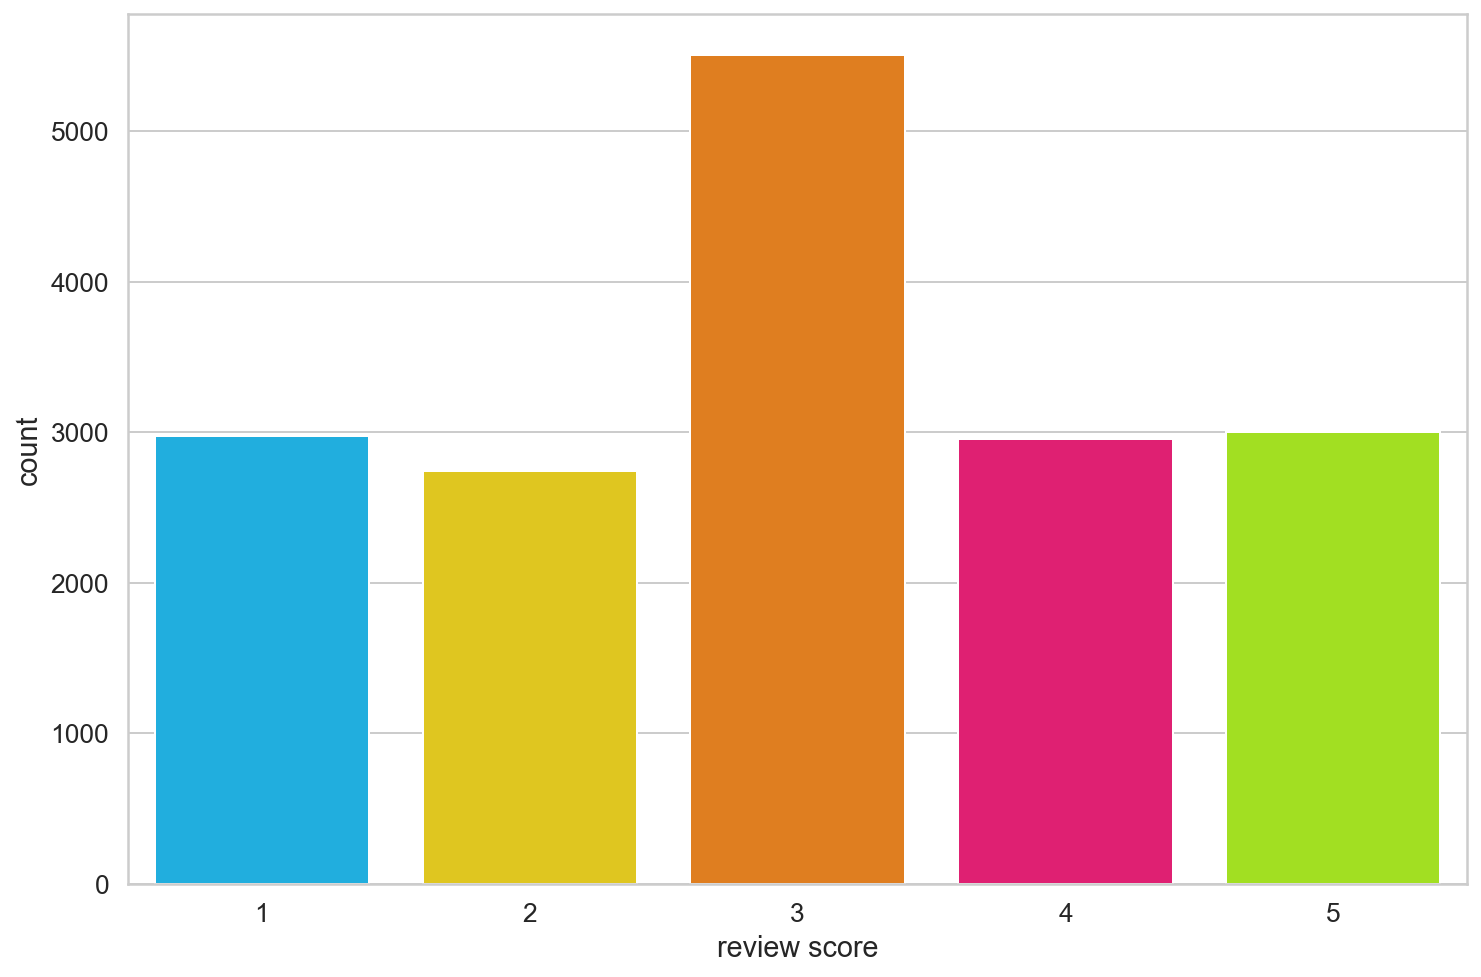

In [42]:
sns.countplot(x=df.score)
plt.xlabel('review score')

In [43]:
def to_sentiment(rating):
    rating = int(rating)
    match rating:
        case 1 | 2:
            return 0
        case 3:
            return 1
        case 4 | 5:
            return 2

In [45]:
df['sentiment'] = df.score.apply(to_sentiment)

In [47]:
df.tail(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appID,sentiment
17178,23db5588-a835-491b-a54b-cd5798434729,lucy shires,https://play-lh.googleusercontent.com/a-/AFdZu...,So helpful,5,0,5.3,2021-12-04 21:03:24,NaN,NaN,newest,com.appxy.planner,2
17179,591f8e58-6e75-4bfc-afde-2b496c32824a,Virginia Faber,https://play-lh.googleusercontent.com/a/AItbvm...,Most perfect planner ever! User friendly with ...,5,2,5.3,2021-12-03 18:47:45,NaN,NaN,newest,com.appxy.planner,2


In [52]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

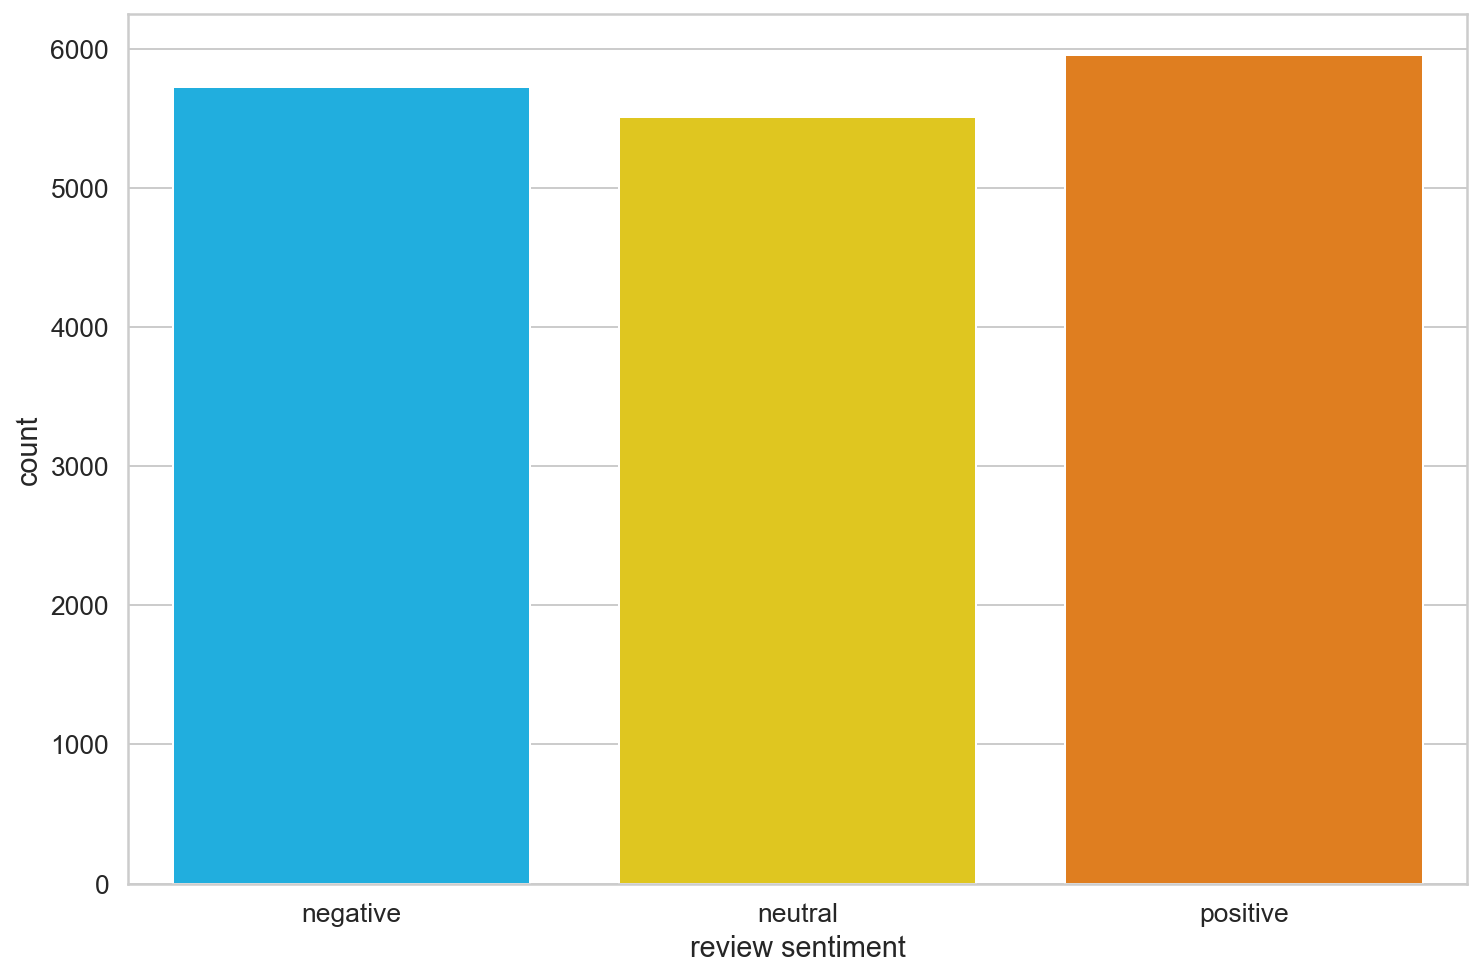

In [53]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [125]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [126]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [56]:
sample_txt = 'When was I last outside? I went to mountain yesterday at night.'

In [57]:
tokens = tokenizer.tokenize(sample_txt)

In [62]:
print(len(tokens))
print(tokens)

14
['when', 'was', 'i', 'last', 'outside', '?', 'i', 'went', 'to', 'mountain', 'yesterday', 'at', 'night', '.']


In [63]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [64]:
print(len(token_ids))
print(token_ids)

14
[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2253, 2000, 3137, 7483, 2012, 2305, 1012]


In [65]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   tokens: {tokens}")
print(f"token_ids: {token_ids}")

 Sentence: When was I last outside? I went to mountain yesterday at night.
   tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'went', 'to', 'mountain', 'yesterday', 'at', 'night', '.']
token_ids: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2253, 2000, 3137, 7483, 2012, 2305, 1012]


### Special Tokens

In [67]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [68]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [69]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [70]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [73]:
encoding = tokenizer.encode_plus(
    text=sample_txt,
    max_length=32,
    add_special_tokens=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

In [74]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [75]:
print(encoding['input_ids'])

tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2253, 2000, 3137, 7483,
         2012, 2305, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


In [77]:
len(encoding['input_ids'][0])

32

In [79]:
print(encoding['attention_mask']) # 1 for tokens that we care about, 0 for paddings

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### Choosing sequence length

In [161]:
token_lens = []

for txt in tqdm(df.content):
    tokens = tokenizer.encode(text=txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 17180/17180 [00:07<00:00, 2170.26it/s]


Text(0, 0.5, 'indices')

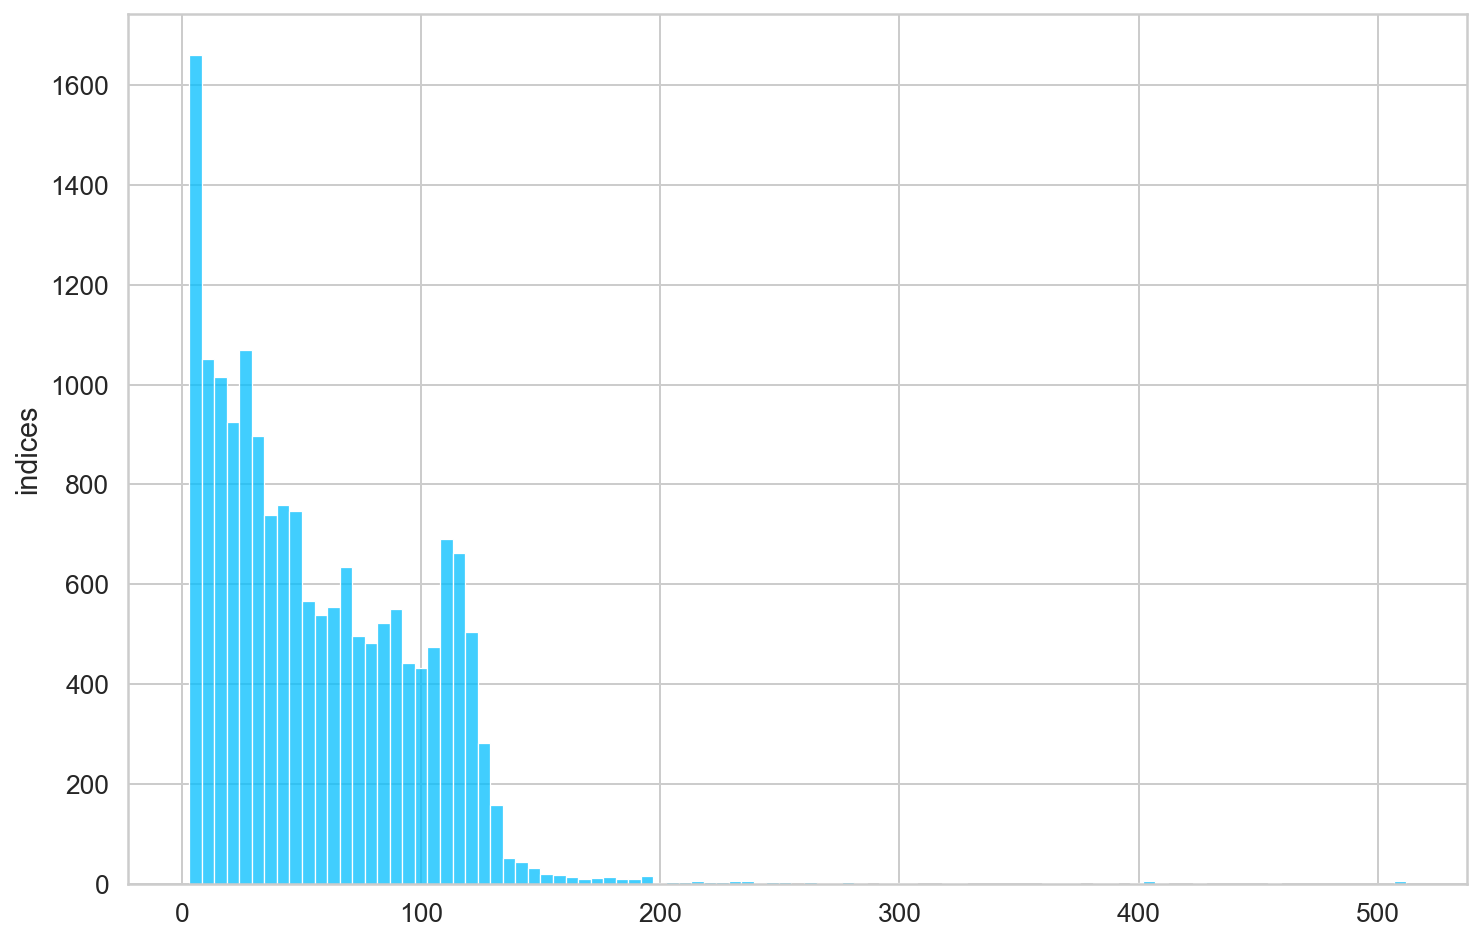

In [162]:
from importlib import reload
plt=reload(plt)

sns.histplot(x=token_lens)
plt.ylabel('indices')

### Create a Dataset

In [177]:
class GPReviewDataset(Dataset):
    
    def __init__(self, review, targets, tokenizer, max_len):
        self.review = review
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
            
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, idx):
        review = str(self.review[idx])
        
        encoding = self.tokenizer.encode_plus(
            text=review,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[idx], dtype=torch.long)
        }

In [164]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS =50

In [165]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [166]:
print(f"df_train.shape: {df_train.shape}")
print(f" df_test.shape: {df_test.shape}")
print(f"  df_val.shape: {df_val.shape}")

df_train.shape: (15462, 13)
 df_test.shape: (859, 13)
  df_val.shape: (859, 13)


In [168]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review = df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
    
    return DataLoader(
        dataset=ds,
        batch_size=batch_size,
        num_workers=os.cpu_count()
    )

In [178]:
train_data_loader = create_data_loader(df=df_train, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
val_data_loader = create_data_loader(df=df_val, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
test_data_loader = create_data_loader(df=df_test, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)

In [179]:
data = next(iter(train_data_loader)) 
print(data.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [180]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [139]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [185]:
encoding

{'input_ids': tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2253, 2000, 3137, 7483,
         2012, 2305, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [193]:
test_model = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [194]:
test_model.last_hidden_state.shape

torch.Size([1, 32, 768])

In [195]:
test_model.pooler_output.shape

torch.Size([1, 768])

## Building sentiment classifier

In [196]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        
        output = self.drop(output.pooler_output)
        output = self.out(output)
        output = self.softmax(output)
        return output

In [202]:
model = SentimentClassifier(len(class_names))
model.to(device)
print(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


In [198]:
# test on sample data
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape, attention_mask.shape)

torch.Size([16, 160]) torch.Size([16, 160])


In [215]:
model = model.eval()
with torch.no_grad():
    pred = model(input_ids=input_ids, attention_mask=attention_mask)

In [216]:
pred.shape

torch.Size([16, 3])

In [222]:
print(data['review_text'][0])
print(pred.shape)
pred[0]

Absolutely no mention of paying to use this app until you've downloaded it and signed up. Too bad, it looked pretty.
torch.Size([16, 3])


tensor([0.2838, 0.4077, 0.3085], device='cuda:0')

### Training
<br> <a href='https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/'>tutorial link</a>

In [214]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer, 
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/media/idham/SpaceX/333_workspace/my_lab/env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [224]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    scheduler,
    n_examples,
    device
):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, targets) # outputs -> (b, num_class)    targets -> (b)
        
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())        
        """ what are step(), backward(), zero_grad() ?
            Hopefully, you use them in the other order - opt.zero_grad(), loss.backward(), opt.step().

            ** zero_grad: clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
            ** loss.backward(): computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
            ** opt.step(): causes the optimizer to take a step based on the gradients of the parameters.

        """
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)
        

In [225]:
def eval_model(model, 
               data_loader, 
               loss_fn, 
               device, 
               n_examples
):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
}

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
nput_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')